# Import Modules

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error


#from keras.models import Sequential, model_from_json
#from keras.layers import Dense, LSTM
#from keras.layers.core import Dense, Activation, Dropout
#from keras.layers.advanced_activations import PReLU
#from keras.optimizers import Adam
#from keras.initializers import Constant
#from keras import backend as K

import matplotlib.pyplot as plt
import gc

In [2]:
# input reshape with multiple locations
def inReshapeMulLoc(data, nTs, nPred, nF):
    data_wide = data.pivot_table(index=['lng', 'lat'], columns='time', fill_value=0)
    data_wide = np.clip(data_wide.reset_index().values, 0, 200)
    del data
    gc.collect()

    nL = data_wide.shape[0]                            # num of locs
    nS = int((data_wide.shape[1] - 2) / nF)            # num of samples  
    nD = int(nS / nTs) - int(nPred/24)                 # num of days to be predicted

    X = np.zeros([nL * nD, nTs, nF + 2], dtype='float32')
    Y = np.zeros([nL * nD, nPred], dtype='float32')

    for i in range(data_wide.shape[0]):
        row = data_wide[i]

        X_sub = np.zeros([nS, nF + 2], dtype='float32')
        X_sub[:, 0] = row[0]
        X_sub[:, 1] = row[1]
        for j in range(nF):
            X_sub[:, 2 + j] = row[2 + nS * j:2 + nS * (j + 1)]

        X[i * nD:(i + 1) * nD] = [X_sub[k * nTs:(k + 1) * nTs] for k in range(nD)]
        Y[i * nD:(i + 1) * nD] = [X_sub[:, 2][(k + 1) * nTs:((k + 1) * nTs + nPred)] for k in range(nD)]

    return X, Y

# input reshape with multiple locations
def inReshapeMulLoc1(data, nTs, nPred, nF):
    data_wide = data.pivot_table(index=['lng', 'lat'], columns='time', fill_value=0)
    data_wide = np.clip(data_wide.reset_index().values, 0, 200)
    del data
    gc.collect()

    nL = data_wide.shape[0]                            # num of locs
    nS = int((data_wide.shape[1] - 2) / nF)            # num of samples  
    nD = int(nS / nTs) - int(nPred/24) - 1             # num of days to be predicted

    X = np.zeros([nL * nD, nTs, nF + 2], dtype='float32')
    Y = np.zeros([nL * nD, nPred], dtype='float32')

    for i in range(data_wide.shape[0]):
        row = data_wide[i]

        X_sub = np.zeros([nS, nF + 2], dtype='float32')
        X_sub[:, 0] = row[0]
        X_sub[:, 1] = row[1]
        for j in range(nF):
            X_sub[:, 2 + j] = row[2 + nS * j:2 + nS * (j + 1)]

        X[i * nD:(i + 1) * nD] = [X_sub[k * nTs:(k + 1) * nTs] for k in range(nD)]
        Y[i * nD:(i + 1) * nD] = [X_sub[:, 2][(k + 2) * nTs:((k + 2) * nTs + nPred)] for k in range(nD)]

    return X, Y


# extract lat, lng and geohash from lat_lng string
#def lat_lng_geo(lng,lat):
#    lng = round(lng,3)
#    lat = round(lat,3)
#    result = pgh.encode(lng, lat)[0:8]
#    return result



# Load Model

In [3]:
from keras.models import model_from_json
# load json and create model
json_file = open('./model/model_bj_l2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./model/model_bj_l2.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [36]:
# load test data
df_data = pd.read_csv('./bj_clu_area3.csv', usecols= ['lng','lat','time', 'flow', 'dm'])
df_data['lng'] = np.round(df_data['lng'],3)
df_data['lat'] = np.round(df_data['lat'],3)
print('Data Loaded')
nLoc = int(df_data['lng'].unique().shape[0] * df_data['lat'].unique().shape[0])
nDay = int(np.ceil(df_data['time'].unique().shape[0] / 24)) - 1
print('Area Size:', nLoc, 'Blocks')
print('Period:', nDay+1, 'Days')

Data Loaded
Area Size: 1435 Blocks
Period: 2 Days


In [37]:
#df_data[df_data['dm']>400]
#plt.plot(df_data[(df_data['lng'] == 116.407) & (df_data['lat'] == 39.912)]['dm'])
#plt.show()

In [38]:
# params
nTs = 24           # number of timesteps to lookback
nPred = 24         # number of timesteps to predict
nF = 4
trn_split = 0.7        # proportion of training set
val_split = 0.25   # proportion of validation set
#fold = 10         # number of CV fold

In [39]:
# partition feature and label
print('Start to Extract Feature and Label...')

X,Y = inReshapeMulLoc(df_data, nTs, nPred, nF-2)
#del df_data
#gc.collect()

print('Done! Extracted ' + str(Y.shape[0]) + ' samples.')

Start to Extract Feature and Label...
Done! Extracted 1435 samples.


In [40]:
# make prediction and print MAE
pred = np.abs(loaded_model.predict(X[:,:,0:4]))

In [41]:
# floor the prediciton value
pred = np.round(pred,0)

In [42]:
print('MAE : ' + str(mean_absolute_error(Y, pred)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(Y, pred))))

MAE : 2.67213
RMSE: 4.85895


In [43]:
b = np.histogram(np.sum(Y,1), bins=[0,10,50,100,200,400,800,5000])
b

(array([174, 419, 323, 288, 164,  56,  11], dtype=int64),
 array([   0,   10,   50,  100,  200,  400,  800, 5000]))

In [32]:
plt.plot(a[0])
plt.show()

NameError: name 'a' is not defined

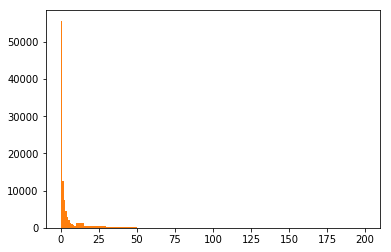

In [108]:
plt.show()

# Result Visualisation

In [11]:
def drawPredOneHour(pred, tgt, hour):
    plt.figure(figsize=(20,5))
    plt.plot(tgt[:,hour], color='mediumpurple',linewidth=1, marker='')
    plt.plot(pred[:,hour], color='mediumseagreen',linewidth=1, marker='')
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    #for i in range(nLoc):
    #    plt.axvline(x=(i+1)*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()
    

In [12]:
def drawPredEveryHour(pred, tgt):
    plt.figure(figsize=(40,20))
    for i in range(24):
        plt.subplot(4,6,i+1)
        plt.plot(tgt[:,i], color='mediumpurple',linewidth=1, marker='')
        plt.plot(pred[:,i], color='mediumseagreen',linewidth=1, marker='')
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.show()
    plt.close()

In [13]:
def drawPredDaily(pred, tgt, day):
    plt.figure()
    plt.plot(tgt[day], color='mediumpurple',marker = "+")
    plt.plot(pred[day], color='mediumseagreen',marker = "+")
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()
    

In [14]:
def print_mae_hourly(pred, tgt):
    error_hourly = np.zeros(nPred, dtype='float32')
    for i in range(nPred):   
         error_hourly[i] = np.mean(abs(pred[:,i]-tgt[:,i]))
    plt.figure()
    plt.plot(error_hourly, color = 'lightseagreen', marker = "+")
    plt.legend(['Hourly Prediction MAE'], loc='upper right', fontsize=10)
    plt.xlabel('Hour')
    plt.ylabel('Error')
    plt.show()
    

In [15]:
def draw_pred_1blk(pred, tgt, blk_index):
    plt.figure(figsize=(15,5))
    plt.plot(tgt[blk_index*nDay:(blk_index+1)*nDay].reshape(-1), color='mediumpurple',marker = "+")
    plt.plot(pred[blk_index*nDay:(blk_index+1)*nDay].reshape(-1), color='mediumseagreen',marker = "+")
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)    
    for i in range(nDay):
        plt.axvline(x=(i+1)*24-1, linestyle='-.', color='k', linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()    
    

In [16]:
def drawAllPred(pred, tgt):
    plt.figure(figsize=(20,5))
    plt.plot(tgt.reshape(-1), color='mediumseagreen',marker = "")
    plt.plot(pred.reshape(-1), color='mediumpurple',marker = "")
#    for i in range(nLoc):
#        plt.axvline(x=(i+1)*24*nDay-1, linestyle='-.', color='k', linewidth=0.5)
    plt.legend(['Real', 'Prediction'], loc='upper left', fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.show()
    plt.close()

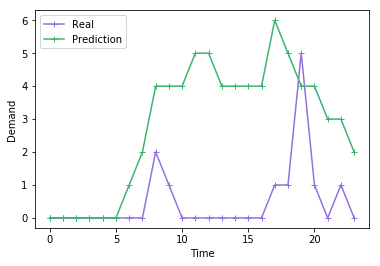

In [18]:
drawPredDaily(pred, Y, 150)

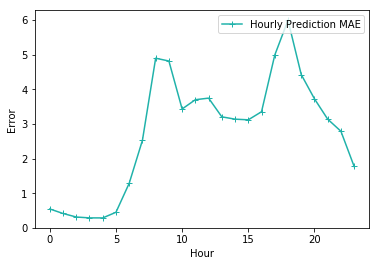

In [19]:
print_mae_hourly(pred, Y)

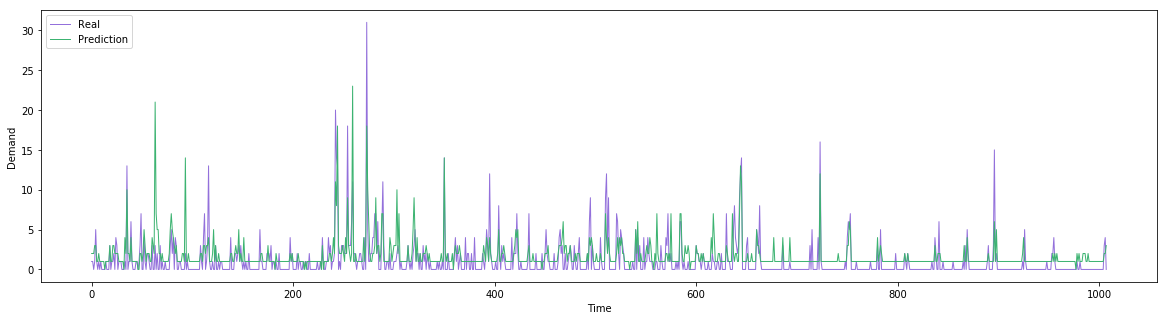

In [20]:
drawPredOneHour(pred, Y, 6)

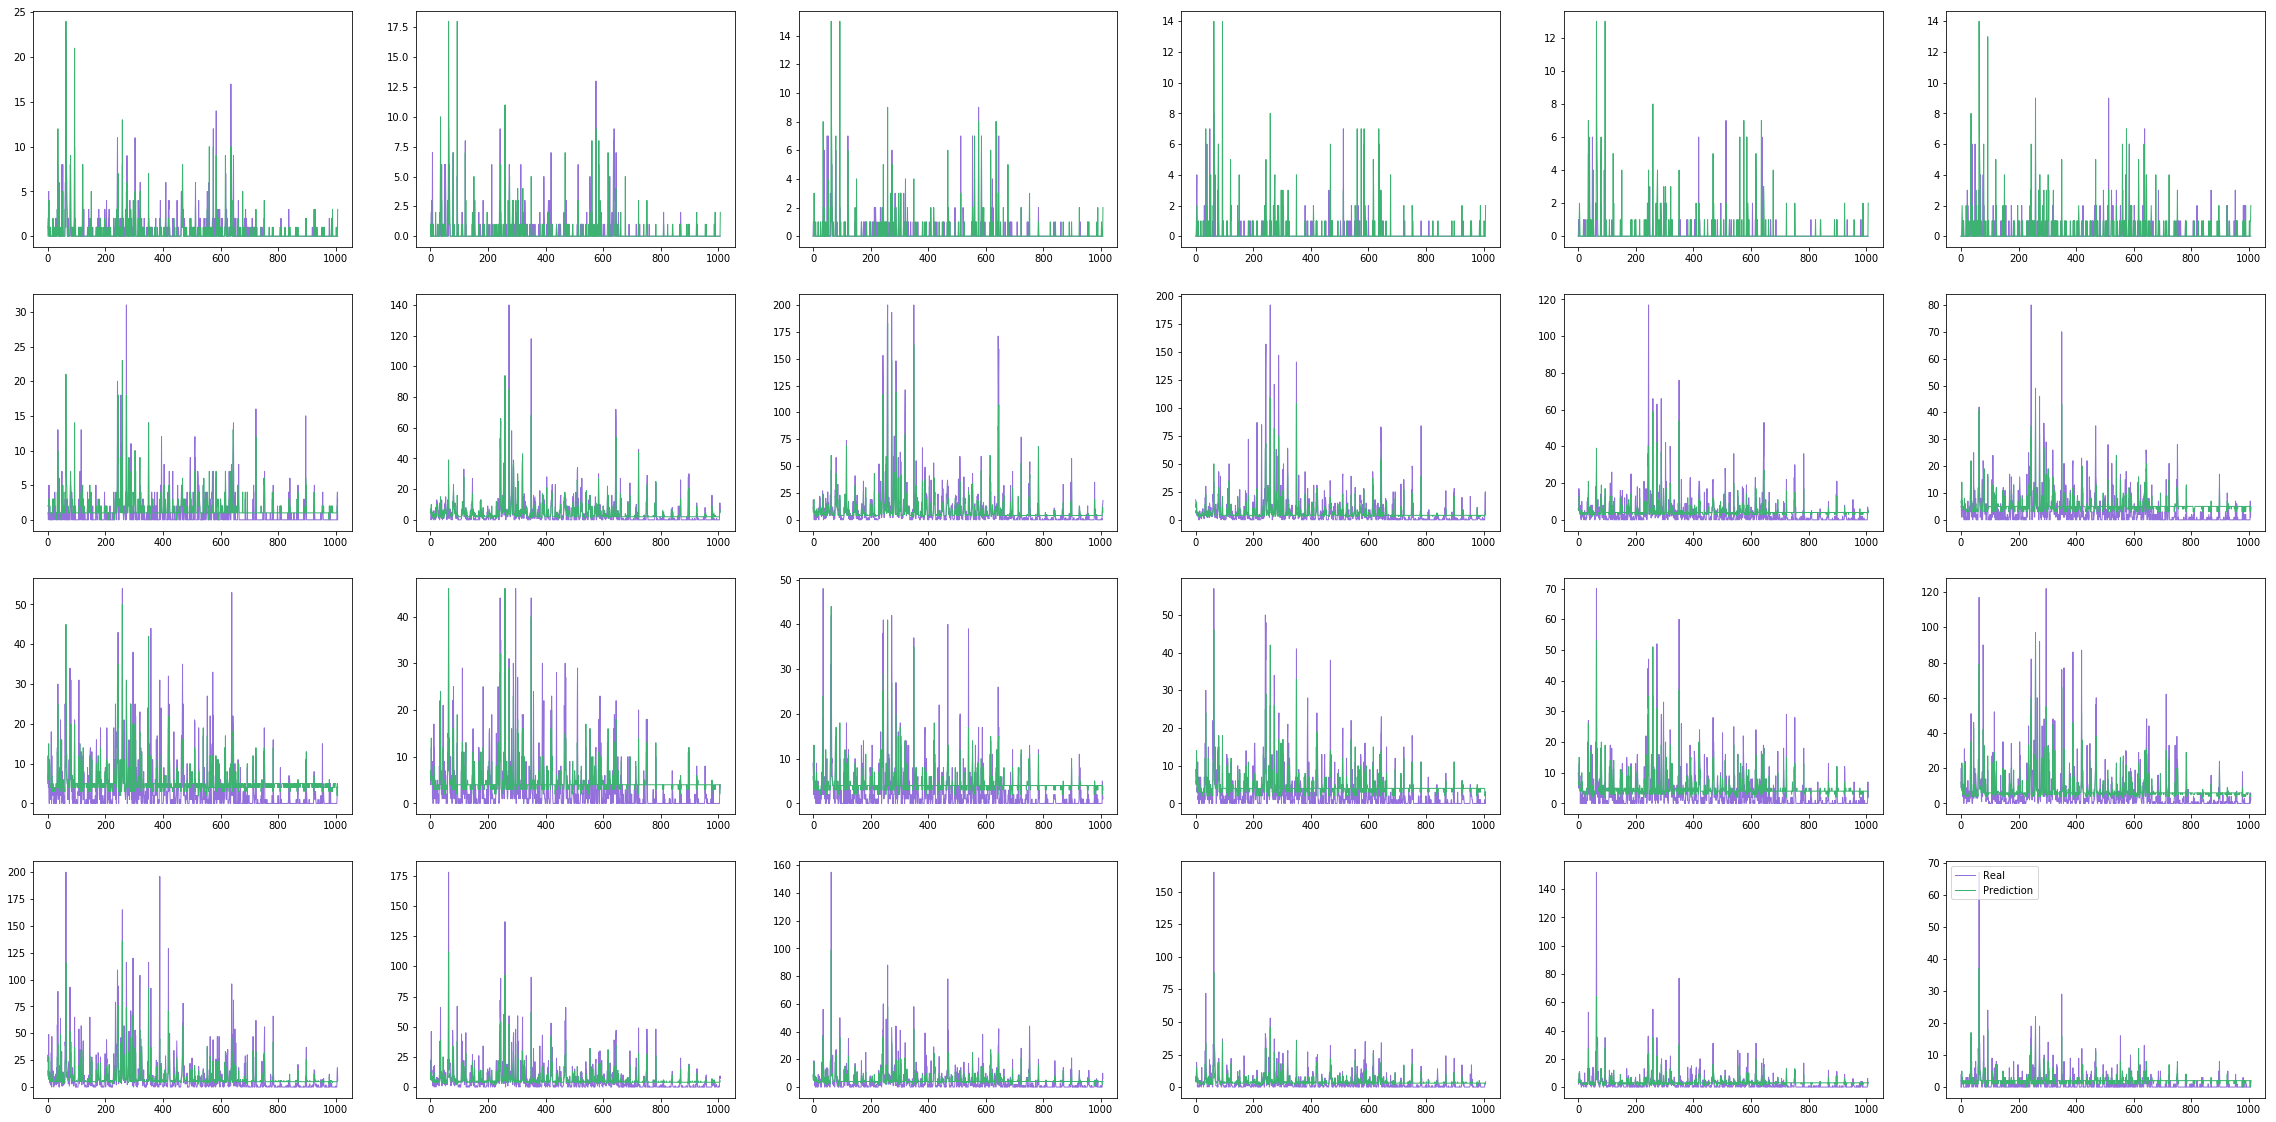

In [21]:
drawPredEveryHour(pred, Y)

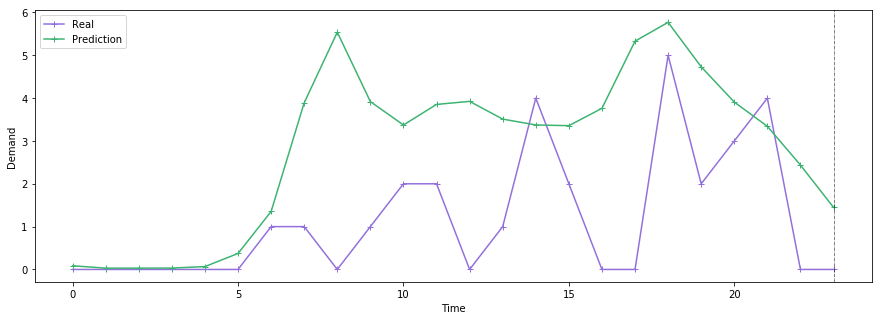

In [22]:
draw_pred_1blk(pred, Y, 66781)

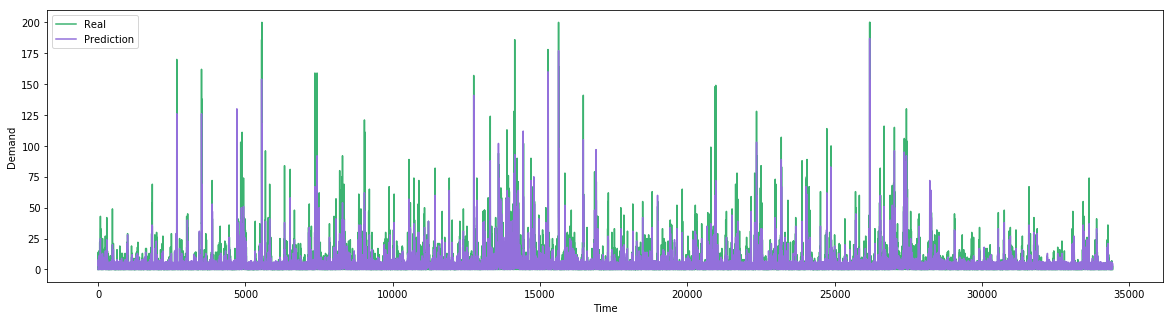

In [44]:
drawAllPred(pred, Y)



#### drawAllPred(Y, pred)

# Output Prediction Results

In [45]:
def print_pred(data):
    data_wide = df_data.pivot_table(index=['lng','lat'], columns='time', fill_value=0)
    
    dm = data_wide.iloc[:,24:24+nDay*24].values.reshape(-1,1)
    
    df_time = data_wide.columns.values[24:24+nDay*24]
    df_time = pd.DataFrame(df_time,columns = ['time'])
    df_time = df_time['time'].apply(lambda x: x[1]).values
    
    df_loc = data_wide.reset_index().iloc[:, 0:2].values
    
    len_time = nDay*24
    len_loc  = len(df_loc)    

    df_time = np.tile(df_time, len_loc).reshape(len_time*len_loc,1)
    df_loc = np.concatenate(np.tile(df_loc, len_time).reshape(len_loc,len_time,2))
    
    df_out = np.concatenate((df_loc, df_time,pred.reshape(-1,1),dm), axis=1)
    del df_loc, df_time
    gc.collect()
    df_out = pd.DataFrame(df_out, columns=['lng','lat','time','dm_pred','dm'])
    df_out['lng'] = np.round(df_out['lng'].astype(np.float64),3)
    df_out['lat'] = np.round(df_out['lat'].astype(np.float64),3)
    
    df_out.to_csv('pred_result_area3.csv', index=False)

    
print_pred(df_data)
    